In [83]:
## Packages

# ##Installs
#!pip install openpyxl transformers

##Imports
import pandas as pd
import transformers
import openpyxl
import numpy

In [84]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


In [85]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [86]:
## Investigate K-means clustering to see whether certain medicines have different side effects - use as baseline to see if there is a significant difference with the transformer model
from sklearn.cluster import KMeans

vocabulary=tfidf.get_feature_names_out()
print(vocabulary)

num_clusters=4
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(tfidfSentences)
top_words=km.cluster_centers_.argsort()
print(vocabulary[top_words])
df['cluster']=km.labels_

['00' '04' '06' ... 'zoning' 'zopiclone' 'zyprexa']


c:\Users\julev\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[['completly' 'professionally' 'filled' ... 'feel' 'like' 'depression']
 ['00' 'or' 'option' ... 'sexual' 'effects' 'side']
 ['00' 'paranoia' 'paramedics' ... 'would' 'take' 'drug']
 ['kidney' 'numerous' 'nurse' ... 'weeks' 'first' 'taking']]


drug_name
cymbalta     1707
effexorxr    1549
lexapro      1492
zoloft       1261
Name: count, dtype: int64
drug_name  cymbalta  effexorxr  lexapro  zoloft
cluster                                        
0              1257       1132     1120     938
1               124        125      108      95
2                86        108       52      49
3               240        184      212     179


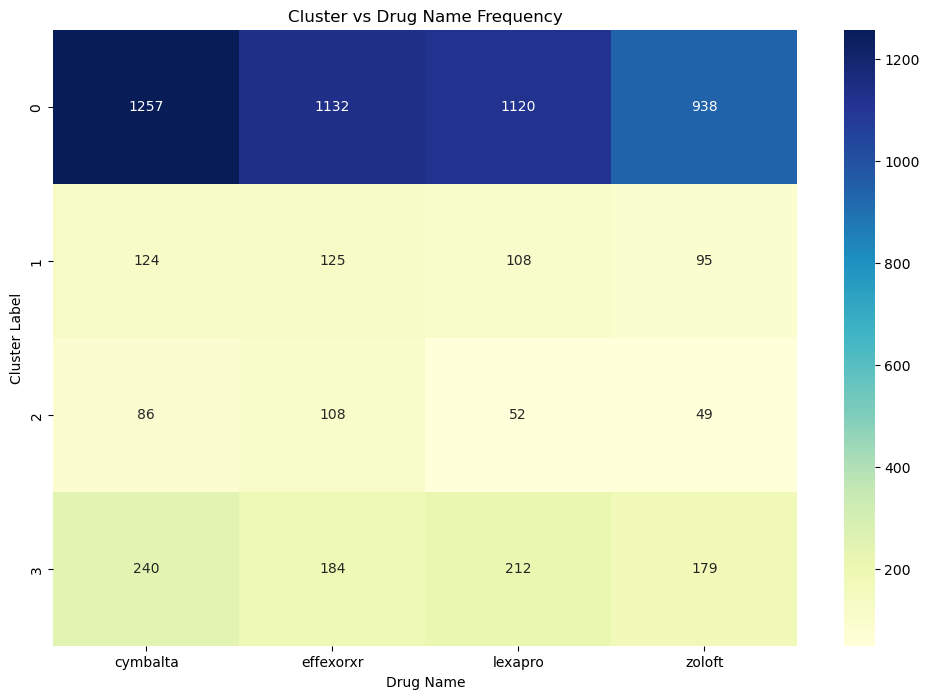

Chi2: 28.1112534254512, p-value: 0.0009138789409678345


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print(df['drug_name'].value_counts())

contingency_table = pd.crosstab(df['cluster'], df['drug_name'])
print(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cluster vs Drug Name Frequency')
plt.ylabel('Cluster Label')
plt.xlabel('Drug Name')
plt.show()

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

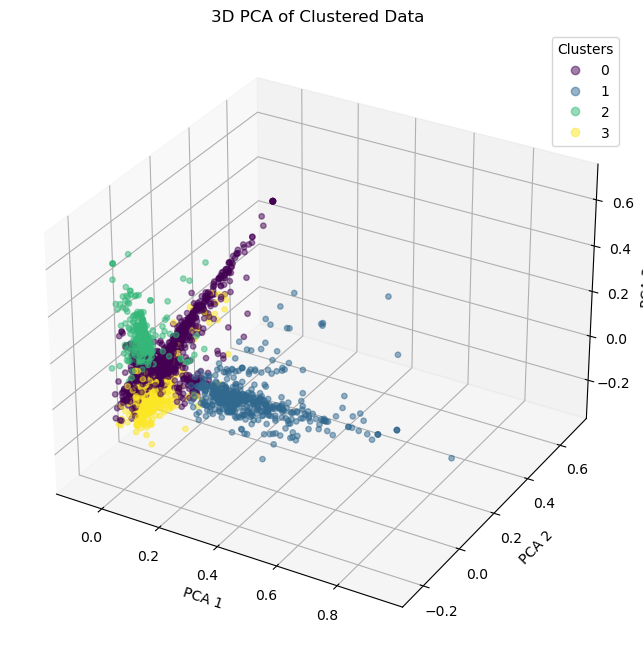

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans


pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=km.labels_, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

legend = ax.legend(*scatter.legend_elements(), loc='upper right', title="Clusters")

plt.title('3D PCA of Clustered Data')
plt.show()

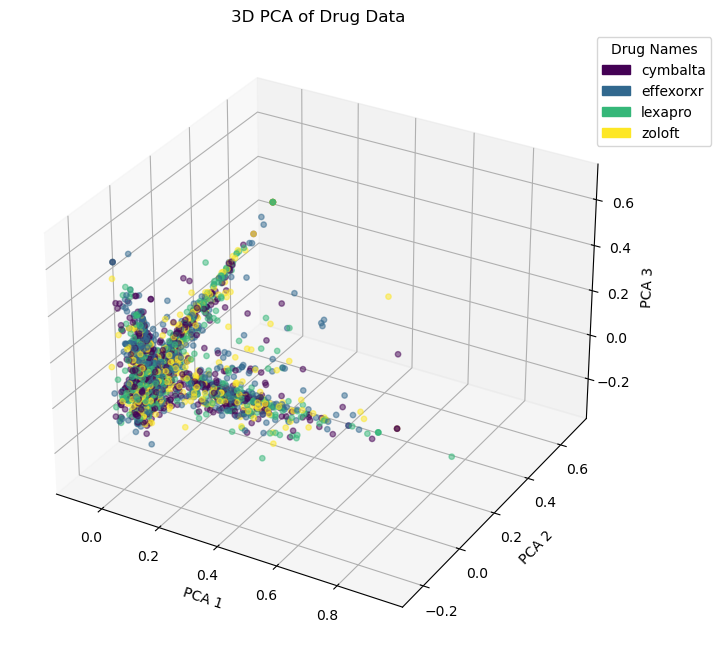

In [89]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
import numpy as np

label_encoder = LabelEncoder()
drug_labels = label_encoder.fit_transform(df['drug_name'])

pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=drug_labels, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

cmap = plt.cm.viridis

legend_handles = [Patch(color=cmap(norm), label=label) for label, norm in zip(label_encoder.classes_, np.linspace(0, 1, len(label_encoder.classes_)))]
ax.legend(handles=legend_handles, title="Drug Names", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('3D PCA of Drug Data')
plt.show()

In [102]:
## Transformers
from sklearn.model_selection import train_test_split

# Features and labels
X = df['sentences'].values
y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
print(y_train)
print(y_val)

[[1.0 0.0 0.0 0.0 0.0 0]
 [0.0 1.0 0.0 0.0 0.0 0]
 [1.0 0.0 0.0 0.0 0.0 0]
 ...
 [0.0 0.0 0.0 0.0 0.0 0]
 [1.0 0.0 0.0 0.0 0.0 0]
 [0.0 0.0 1.0 0.0 0.0 0]]
[[1.0 0.0 0.0 0.0 0.0 0]
 [0.0 0.0 1.0 0.0 1.0 1]
 [0.0 0.0 0.0 1.0 0.0 0]
 ...
 [0.0 0.0 0.0 0.0 0.0 0]
 [0.0 0.0 0.0 0.0 0.0 0]
 [0.0 0.0 0.0 0.0 0.0 0]]
